In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from os import path
from glob import glob
import math
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
plt.gray() # Make images gray
import numpy as np
from skimage.transform import resize

from dumbrain.lib.download import downloadAndUnzip

<Figure size 432x288 with 0 Axes>

### First, get the data

In [3]:
downloadAndUnzip( 'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip', 'data/' )
downloadAndUnzip( 'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip', 'data/' )

9478144it [00:05, 1666215.43it/s]                             
100%|██████████| 4810560/4810560 [00:03<00:00, 1401663.55it/s]
6471680it [00:03, 1739899.97it/s]                             
100%|██████████| 3371735/3371735 [00:02<00:00, 1406871.61it/s]


### Understanding the data, and the problem

Fellowship.ai challenge problem statement

> Omniglot, the “transpose” of MNIST, with 1623 character classes, each with 20 examples.  Build a few-shot classifier with a target of <35% error.

30 20


(array([ 4.,  4., 16.,  3.,  3.,  0.,  9.,  6.,  3.,  2.]),
 array([14. , 18.1, 22.2, 26.3, 30.4, 34.5, 38.6, 42.7, 46.8, 50.9, 55. ]),
 <a list of 10 Patch objects>)

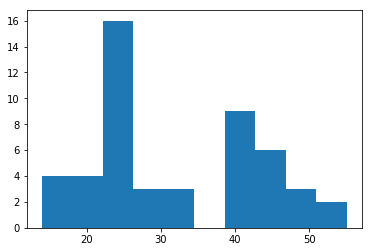

In [4]:
background_language_folders = glob( 'data/images_background/*' )
evaluation_language_folders = glob( 'data/images_evaluation/*' )
print( len( background_language_folders ), len( evaluation_language_folders ) )

character_counts = np.zeros( len( background_language_folders ) + len( evaluation_language_folders ), dtype=np.int )
for i, language_folder in enumerate( background_language_folders + evaluation_language_folders ):
    characters = glob( f'{language_folder}/*' )
    character_counts[ i ] = len( characters )

plt.hist( character_counts )

Looks like the background set contains 30 languages and the evaluation 20. Based on the omniglot readme:

> To compare with the results in our paper, only the background set should be used to learn general knowledge about characters (e.g., hyperparameter inference or feature learning). One-shot learning results are reported using alphabets from the evaluation set.

The goals is to build a meta learner that learns about identifying characters from the 30 background languages, and is able to identify characters in the evaluation set after seeing only a few examples (Either 1 example for 1-shot learning, or 5 examples for 5-shot learning). From the associated paper ([attached](lake2015.pdf)) it appears that the evaluation was done by asking classifiers to pick out a match of the character from a set of 20 characters in the same language. As quoted here:

> a single image of a new character was presented, and participants selected another example of that same character from a set of 20 distinct characters produced by a typical drawer of that alpha-bet

From other papers this is what is known as a 20-way classification, other people seem to test models on a 5-way classification as well.

I think it would be valuable to test our model on all-way (which would be the real-world use of the model), 20-way and 5-way (for comparison with academic results) classification. The problem statement states few-shot (Which references 5-shot learning), however I think it is worthwile to test the model on 1-shot learning as well.

### Data exploration

Now that we have a decent idea of the problem at hand, let's start looking through the data

In [5]:
# Load all images into memory
x_sizes, y_sizes = [], [] # Check image sizes to see if they all match
def loadLanguage( language_folder ):
    language = []
    for character_folder in glob( f'{language_folder}/*' ):
        character = []
        for character_image in glob( f'{character_folder}/*' ):
            image = plt.imread( character_image )
            x_sizes.append( image.shape[ 0 ] )
            y_sizes.append( image.shape[ 1 ] )
            character.append( image )
        language.append( np.array( character ) )
    return np.array( language )

background_languages = [ loadLanguage( folder ) for folder in background_language_folders ]
evaluation_languages = [ loadLanguage( folder ) for folder in evaluation_language_folders ]

In [6]:
# Check sizes
print( np.unique( x_sizes ), np.unique( y_sizes ) )

[105] [105]


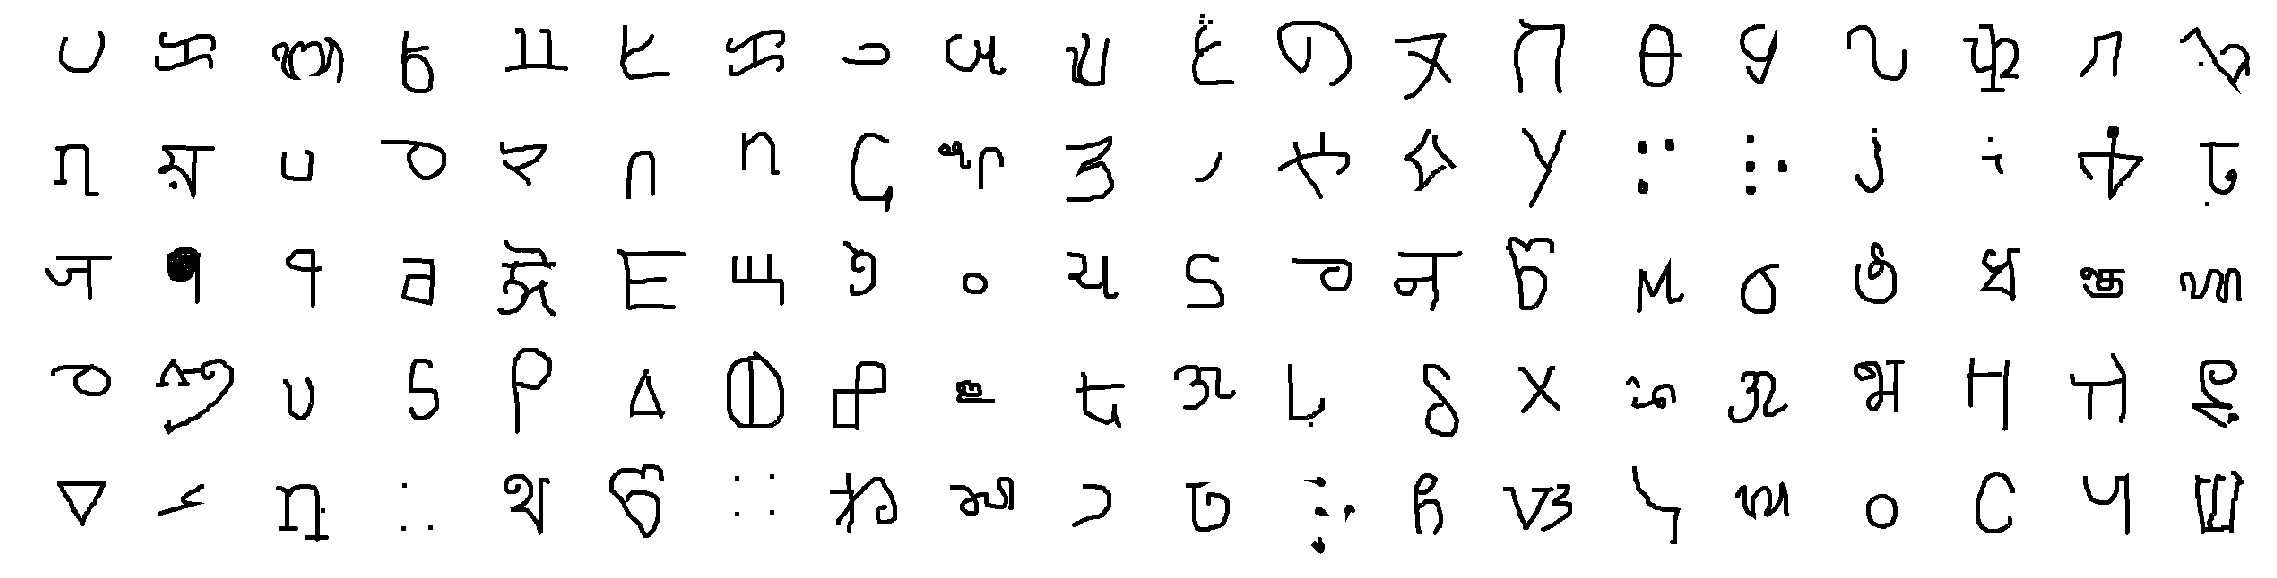

In [7]:
# Plot some random images
fig = plt.figure( figsize=( 40, 10 ) )
subplots = np.array( fig.subplots( 5, 20 ) ).flatten()

def getRandomImage( image_set, language_idx=None, character_idx=None, image_idx=None ):
    if language_idx is None:
        language_idx = np.random.randint( len( image_set ) )
    if character_idx is None:
        character_idx = np.random.randint( len( image_set[ language_idx ] ) )
    if image_idx is None:
        image_idx = np.random.randint( len( image_set[ language_idx ][ character_idx ] ) )
    return image_set[ language_idx ][ character_idx ][ image_idx ]

for subplot in subplots:
    subplot.axis( 'off' )
    subplot.imshow( getRandomImage( background_languages ) )

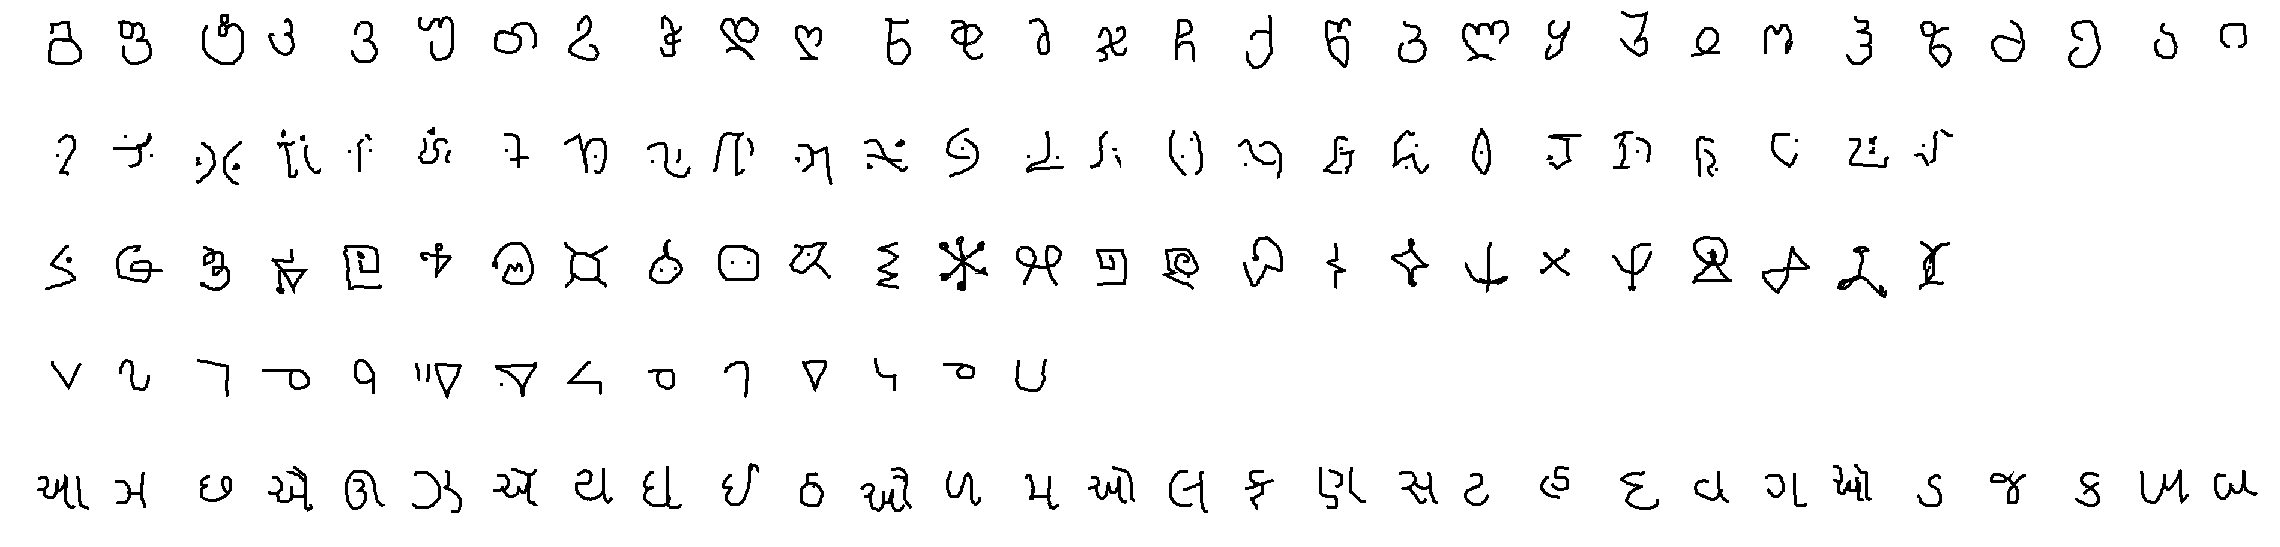

In [8]:
# Let's look at all the characters for a few different languages
fig = plt.figure( figsize=( 40, 10 ) )
subplots = fig.subplots( 5, 30 )

for row in subplots:
    language_idx = np.random.randint( len( background_languages ) )
    for character_idx, subplot in enumerate( row ):
        subplot.axis( 'off' )
        if character_idx >= len( background_languages[ language_idx ] ):
            continue # Continue so we still call .axis off
        subplot.imshow( getRandomImage( background_languages, language_idx, character_idx ) )

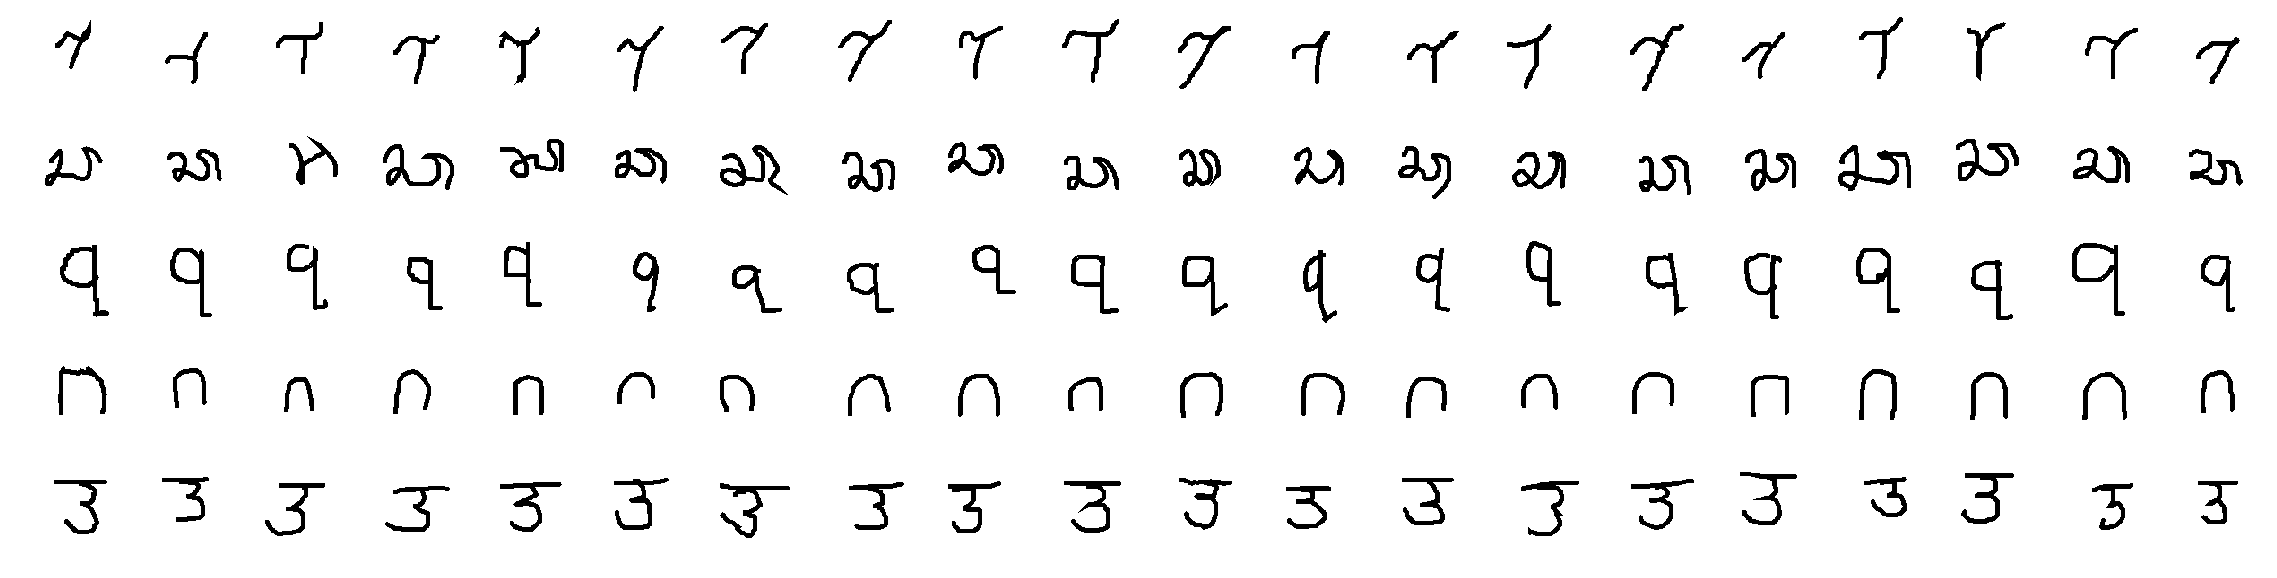

In [9]:
# Finally, let's look at all the drawings for a few different characters
fig = plt.figure( figsize=( 40, 10 ) )
subplots = fig.subplots( 5, 20 )

for row in subplots:
    language_idx = np.random.randint( len( background_languages ) )
    character_idx = np.random.randint( len( background_languages[ language_idx ] ) )
    for image_idx, subplot in enumerate( row ):
        subplot.axis( 'off' )
        subplot.imshow( getRandomImage( background_languages, language_idx, character_idx, image_idx ) )

Notes / Thoughts:

 1. Different characters within a language seem to have similar characteristics (ie. some languages use alot of dots, some are very low detail), but be fairly visually different
 1. Different drawings of the same character can have pretty wide variation in size and stroke. Given this, it should be easy to augment the data by generating random zoom / offsets of the characters
     - May be able to do some "distortion" augmentation with randomly distorted characters
 1. All of the pixels are 1/0
 1. It seems like the images can be easily scaled down without losing much detail to improve training performance

### Research papers, external research

 - The [Lake et al. 2015](lake2015.pdf) paper that is attached to this dataset names a few different approaches
     - They mention that their baseline of simple [Hausdorff Distance](https://en.wikipedia.org/wiki/Hausdorff_distance) on centered images, they are able to get an error of 38%. Based on our problem statement, our target error is <35%, so this approach may work. Since it is fairly simple to implement we can try this first to get a feel for the problem and create some support tools.
     - The novel technique mentioned in this paper is Bayesian Program Learning (BCL) which attempts to break down characters into a sequence of "parts" or strokes taken when drawing the character. While this is an interesting approach, it is more complicated and less accurate than approaches found in later literature.
 - There are several other papers using the omniglot dataset and getting great results (Accuracy is listed as: 5-way 1-shot, 5-way 5-shot, 20-way 1-shot, 20-way 5-shot)
     - Matching networks (98.1%, 98.9%, 93.8%, 98.7%): https://arxiv.org/pdf/1606.04080.pdf
     - Convolutional Siamese Nets (97.3%, 98.4%, 88.1%, 97.0%): https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
     - Prototypical Network (98.8%, 99.9%, 96.0%, 98.9%): http://papers.nips.cc/paper/6996-prototypical-networks-for-few-shot-learning.pdf

Based on my research it looks like the current state of the art algorithms are getting 99-95% accuracy on the defined tasks. 96% accuracy is what we can expect on the hardest version of the problem (20-way, 1-shot).

After this research I have decided to implement the Prototypical Network for a few reasons:
 - It shows the best accuracy on the problem
 - The paper uses downsized versions of the images (28x28 pixels). Which should allow me to train quickly on my poor hardware
 - The paper only uses 90 degree rotational augmentation, I want to try improving generalizability with other augmentations

### Model Support Code

To make it simpler down the line to train/test the model against the different data-sets, I am going to create some support code for the different sets

In [10]:
class Model( ABC ):
    """
    Base class for defining a n-shot model
    """
    def __init__( self, classes ):
        self.classes = classes

    @abstractmethod
    def predict( self, image ):
        """
        Given an image, predict it's class
        
        Args:
            image: The image to classify
        """
        pass

class RandomModel():
    """Example random model used to test support code"""
    def predict( self, image ):
        return np.random.randint( self.classes.shape[ 0 ] )

30


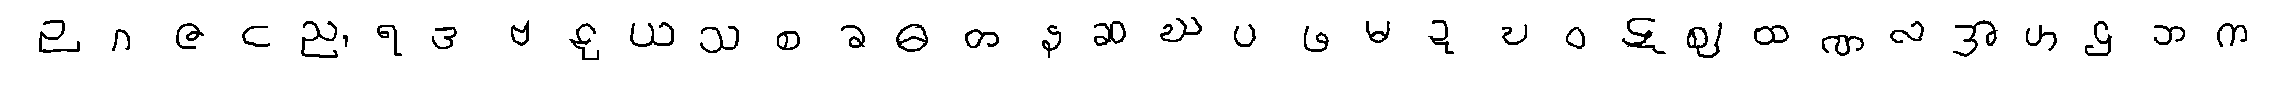

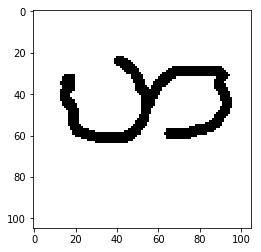

In [19]:
def getShots( character, shots=1 ):
    character = character.copy()
    np.random.shuffle( character )
    return character[ 0:shots ]

def generateExample( characters, ways=None, shots=1 ):
    character_order = np.random.permutation( characters.shape[ 0 ] )

    random_characters = characters[ character_order ]

    if ways is None:
        ways = len( characters ) - 1

    test_shots = getShots( random_characters[ 0 ], shots + 1 )
    test_image = test_shots[ 0 ]
    target_images = test_shots[ 1: ]

    random_images = np.array( [ getShots( character, shots ) for character in random_characters[ 1:1+ways ] ] )
    random_images = np.append( random_images, target_images[ None, ... ], axis=0 )

    random_images_order = np.random.permutation( random_images.shape[ 0 ] )
    target_idx = np.where( random_images_order == random_images.shape[ 0 ] - 1 )[0][0]
    random_images = random_images[ random_images_order ]

    return random_images, test_image, target_idx

In [ ]:
random_images, test_image, target_idx = generateExample( background_languages[ 0 ], ways=None, shots=1 )

fig = plt.figure( figsize=( 40, 5 ) )
subplots = fig.subplots( 1, random_images.shape[ 0 ] )
for i, subplot in enumerate( subplots ):
    subplot.axis( 'off' )
    subplot.imshow( random_images[ i, 0 ] )
plt.subplots()
plt.imshow( test_image )
print( target_idx )

13


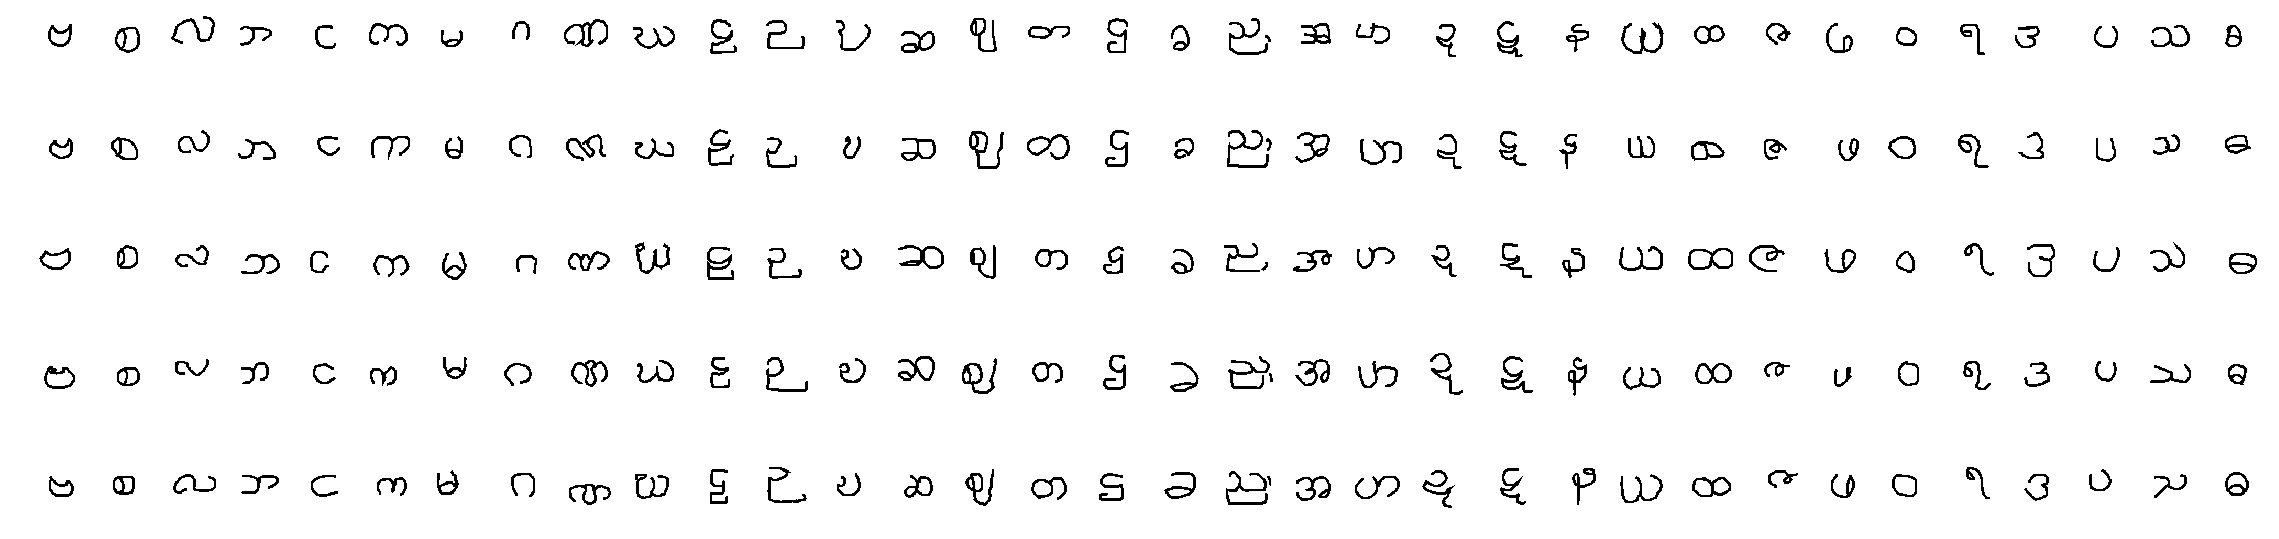

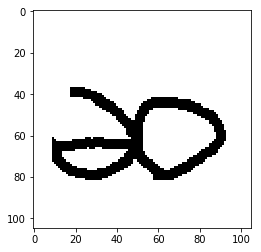

In [21]:
random_images, test_image, target_idx = generateExample( background_languages[ 0 ], ways=None, shots=5 )

fig = plt.figure( figsize=( 40, 10 ) )
subplots = fig.subplots( 5, random_images.shape[ 0 ] )
for row_i, row in enumerate( subplots ):
    for i, subplot in enumerate( row ):
        subplot.axis( 'off' )
        subplot.imshow( random_images[ i, row_i ] )

plt.subplots()
plt.imshow( test_image )
print( target_idx )

### First model: Hausdorff Distance minification

The Lake et al. 2015 paper compares their results to a baseline of choosing the centered image with the lowest Hausdorff Distance. This should be easy to build and evaulate